### Look into Socure
---

Especially the Sigma (fraud_score_2), how does the missing value or lower value impact the result

In [5]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
with open('../../models/customer_risk_target_no_giact_time_since_last_link.pkl', 'rb') as f:
    model = pickle.load(f)
    
modeling_df = pd.read_feather('../../artifacts/modeling_df_final_with_oof_preds_replication.feather')

In [7]:
cols_raw = ['first_deposit_amount', 'vantage_score', 'bcc7120', 'email_risk_score', 
            'fraud_score_2', 'name_email_correlation', 'transaction_as_pct_of_balance', 
            'mean_account_balance_30d', 'phone_risk_score',
            'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction', 
            'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions', 
            'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
            'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d', 
            'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits', 
            'time_since_last_transaction', 'bal_ratio', 'name_phone_correlation', 
            'giact_nr_other', 'dollar_val_returns', 'nr_trans_ratio', 'iqt9413', 
            'dollar_val_returns_3d', 'nr_returns_30d', 'credit_card_loan_amount',
            'fraud_score_1', 'age_money_account']

cols_raw_ni = ['transaction_code']

cols_encoded = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']

# use cols_encoded to offer a second dimension to treat special feature values.
# check out bcc7120 for example: bcc7120 have nan for special values, and 
#         bcc7120 default encoded has -1 for non-defaults and copies for special values
# see utils for example
features = cols_raw + cols_encoded

default_values = {
    'vantage_score': [pd.Interval(300, 850), False],
    'all7120': [pd.Interval(0, 990), True],
    'all8220': [pd.Interval(0, 9990), False],
    'bcc7120': [pd.Interval(0, 990), True],
    'iln5520': [pd.Interval(0, 999999990), False],
    'iqt9413': [pd.Interval(0, 90), False]
}


In [9]:
from utils import train_lgb_baseline_grouped, preprocess
modeling_df = preprocess(modeling_df)

#### Behavior
---
Extra group of people is onboarding as Group 4a.

#### Hypothesis 1: new Socure data and Sigma score

In [43]:
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_shap_dependence(df, shap_values, features, ncols=6, figsize=None, place_holder=True, **kwargs):
    """
    Build the partial dependence plot for a set of models and features.
    """
    nrows = math.ceil(len(features) / ncols)

    if figsize is None:
        figsize = (ncols * 6, nrows * 6)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axs = axs.flatten()
    placeholder_i = 0
    for i in range(len(features)):
        feature = features[i]
        
        ax = axs[i]
        shap.dependence_plot(feature, shap_values, df, 
                             ax=ax, show=False, **kwargs)
        rlim = df[feature].max() #df[feature].quantile(0.98)
        llim = df[feature].min() # df[feature].quantile(0.02) - ((rlim - df[feature].quantile(0.02)) / 12)
            
        if rlim < np.inf and llim > -np.inf:
            ax.set_xlim(left=llim, right=rlim)
            
    return fig

In [10]:
from utils import scale_scores
modeling_df['score'] = scale_scores(modeling_df['pred'])
modeling_df[['pred', 'score']].head()

,pred,score
0,0.085010,558.730520
1,0.017006,506.938453
2,0.055994,544.903416
3,0.025013,519.078743
4,0.002954,452.564025


In [11]:
socure_features = ['vantage_score', 'fraud_score_1', 'fraud_score_2', 'phone_risk_score', 'email_risk_score']

In [22]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(modeling_df[features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


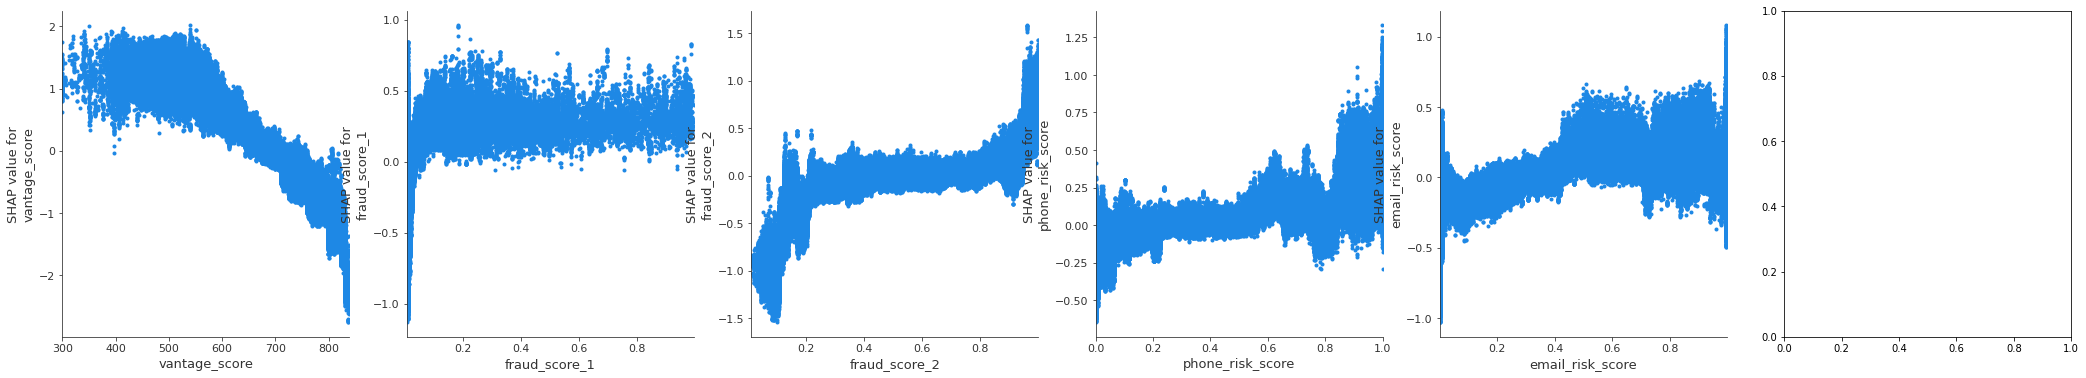

In [24]:
fig = get_shap_dependence(modeling_df[features], shap_values[1], 
                          socure_features, interaction_index=None)

#### Where Sigma is nan

In [39]:
sigma_isna_df = modeling_df[modeling_df.fraud_score_2.isna()].sample(10000)
sigma_isna_df.shape

(10000, 49)

In [45]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model)
sigma_isna_shap = explainer.shap_values(sigma_isna_df[features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


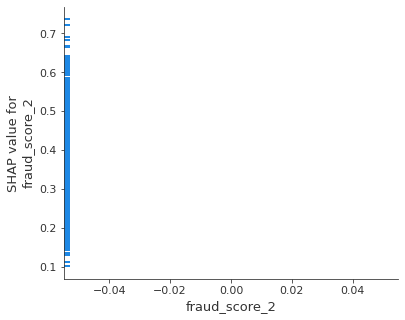

In [47]:
shap.dependence_plot('fraud_score_2', sigma_isna_shap[1], sigma_isna_df[features], interaction_index=None)

No Sigma score is treated as 0 sigma score

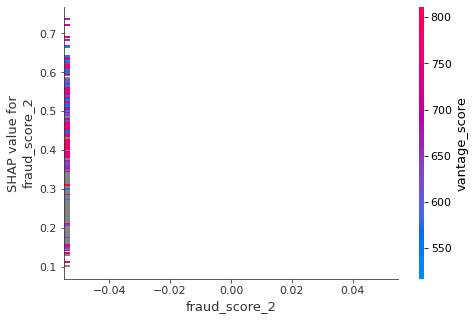

In [49]:
shap.dependence_plot('fraud_score_2', sigma_isna_shap[1], sigma_isna_df[features], 
                     interaction_index='vantage_score')

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


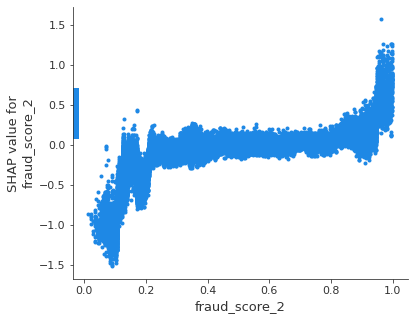

In [54]:
sigma_isna_df = modeling_df.sample(100000)
sigma_isna_df.shape

shap.initjs()
explainer = shap.TreeExplainer(model)
sigma_isna_shap = explainer.shap_values(sigma_isna_df[features])
shap.dependence_plot('fraud_score_2', sigma_isna_shap[1], sigma_isna_df[features], 
                     interaction_index=None)

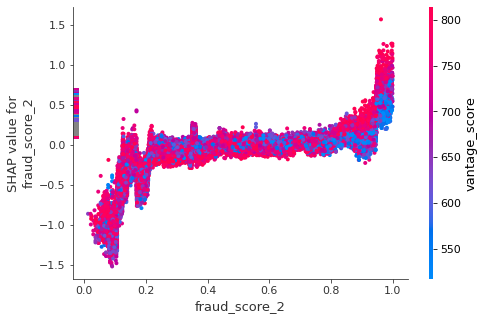

In [55]:
# Sigma interaction with the others
shap.dependence_plot('fraud_score_2', sigma_isna_shap[1], sigma_isna_df[features], 
                     interaction_index='vantage_score')

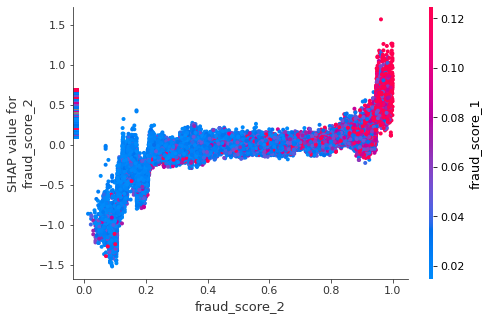

In [56]:
# Sigma interaction with the others
shap.dependence_plot('fraud_score_2', sigma_isna_shap[1], sigma_isna_df[features], 
                     interaction_index='fraud_score_1')

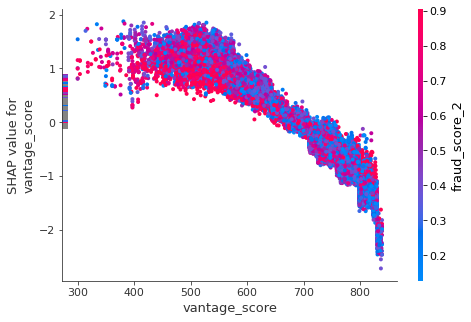

In [58]:
# Sigma interaction with the others
shap.dependence_plot('vantage_score', sigma_isna_shap[1], sigma_isna_df[features], 
                     interaction_index='fraud_score_2')

In [60]:
list(zip(model.feature_name_, model.feature_importances_))

[('first_deposit_amount', 752),
 ('vantage_score', 960),
 ('bcc7120', 684),
 ('email_risk_score', 810),
 ('fraud_score_2', 1062),
 ('name_email_correlation', 615),
 ('transaction_as_pct_of_balance', 438),
 ('mean_account_balance_30d', 700),
 ('phone_risk_score', 705),
 ('name_address_correlation', 547),
 ('all8220', 851),
 ('lag_acc_open_first_transaction', 586),
 ('dollar_val_dd', 385),
 ('all7120', 580),
 ('sum_deposits_10d', 428),
 ('nr_past_transactions', 590),
 ('total_tradelines_open', 486),
 ('education_loan_amount', 393),
 ('address_risk_score', 629),
 ('iqt9415', 213),
 ('max_withdrawals_30d', 124),
 ('iln5520', 743),
 ('max_deposits_30d', 410),
 ('pct_returned_deposits', 175),
 ('giact_nr_decline', 268),
 ('nr_direct_deposits', 152),
 ('time_since_last_transaction', 103),
 ('bal_ratio', 315),
 ('name_phone_correlation', 211),
 ('giact_nr_other', 178),
 ('dollar_val_returns', 151),
 ('nr_trans_ratio', 184),
 ('iqt9413', 100),
 ('dollar_val_returns_3d', 132),
 ('nr_returns_30d'